<a href="https://colab.research.google.com/github/guiraposo/PINNs_Core/blob/main/Simple_Examples/PINNs_ODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Physics-informed neural networks for ODE solving.
In this notebook we will see how to use Physics-informed neural networks (PINNs) to solve differential equations. In this notebook we will start with the simplest case: systems of ODEs. Based on:

 - Maziar Raissi, Paris Perdikaris, George Em Karniadakis, <i>Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations</i>, Journal of Computational Physics, 378, 686-707, 2019. https://arxiv.org/abs/1711.10561


In [26]:
import numpy as np
import sympy as sp

#Torch libraries
import torch
import torch.nn as nn
import torch.optim as optim

import copy


#Plots and Graphic libraries
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.gridspec as gridspec
from matplotlib import animation
from IPython.display import HTML

# Auxiliary functions

In [27]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

def calculate_mape_torch(y_true, y_pred):
    y_true, y_pred = y_true.float(), y_pred.float()
    non_zero_mask = y_true != 0  # Avoid division by zero
    mape = torch.mean(torch.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    return mape

In [28]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! Running on GPU.")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available! Running on GPU.


In [29]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [30]:
def initialize_plots():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plt.rc('font', size=19)
    return fig, ax1, ax2

In [31]:
def update_model(optimizer, loss_function, scheduler, x, min_loss, model, best_model, args, kwargs):
    optimizer.zero_grad()
    loss = loss_function(x, *args, **kwargs)
    loss.backward()
    optimizer.step()

    if scheduler:
        scheduler.step()

    current_loss = loss.item()
    if current_loss < min_loss:
        min_loss = current_loss
        best_model = copy.deepcopy(model.state_dict())
    return current_loss, min_loss, best_model

In [32]:
def update_plots(ax1, ax2, window_min_loss, x, model, x_range, y_true, current_lr,label, args, kwargs):
    ax1.cla()
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_yscale('log')
    ax1.plot(window_min_loss)
    ax1.legend([f"Total Loss (LR: {current_lr:.2e})"], fontsize='small')

    y_model = model(x, *args, **kwargs).cpu().detach().numpy()
    ax2.cla()
    ax2.set_xlabel('x')
    ax2.set_ylabel('y(x)')
    ax2.plot(x.cpu().detach().numpy(), y_model)
    ax2.plot(x_range, y_true, color='#ff7f0e', linestyle='--')
    ax2.legend(["y(x)", "$y="+label+"$"], fontsize='small')
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()

    display.display(plt.gcf())
    display.clear_output(wait=True)
    plt.tight_layout()


In [33]:
def train_model(model, loss_function, optimizer, scheduler, x, y_true, x_range, num_epochs, label, *args, **kwargs):
    
    ################## Training and Plotting ##################
    
    # Initilize the variables for training and visualization
    loss_hist = []  # Total loss
    window_min_loss = []  # Windowed minimum loss
    min_loss = float('inf')
    best_model = None

    # Plotting framework
    fig, ax1, ax2 = initialize_plots()
    
    for epoch in range(num_epochs):
        
        current_loss, min_loss, best_model = update_model(optimizer, loss_function, scheduler, x, min_loss, model, best_model, args, kwargs)
        
        loss_hist.append(current_loss)
        
          
        # Calculate windowed minimum loss
        if epoch >= 100:
            # Find the minimum loss in the current window
            window_min = min(loss_hist[-100:])
        else:
            # If epoch < window_size, just take the minimum of what we have
            window_min = min(loss_hist)

        # Save the window minimum loss for plotting
        window_min_loss.append(window_min)

        if epoch % 100 == 0:
            current_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.defaults['lr']
            update_plots(ax1, ax2, window_min_loss, x, model, x_range, y_true, current_lr, label, args, kwargs)

    
        #except KeyboardInterrupt:
            #break
        # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return model, loss_hist, min_loss


# Case 1. Single Ordinary Differential Equation (ODE)

Let us build a simple Neural Network to approximate the solution of a single ODE as a preliminary example of more complex problems that can be solved and to try simple techniques to optimize the method.

Consider the equation:
$$ y'(x) = 2 x.$$

The solution is trivially $ y = x^2 + c$, where $c$ is an arbitrary constant specified by some initial conditions.

In addition to build the network we will use this simple case to study two methods to enforce the boundary conditions.

1. Strong-enforcement of boundary condition.
2. Weak-enforcement of boundary conditions.

Let us impose that the initial conditions are $y(0)=5 ⇒ c=5 $ and hard force this condition on the network.


## 1.a) Strong-enforcement:

To force the boudnary conditions on our approximated solution we will multiply the output of the neural network by a factor:
$$ y \to y (x-x_0) + y_0,$$
where $y_0=y(x_0)$.

The first tem vanishes when $x=x_0$ guaranteeing that the output at the boundary $x=x_0$ is always $y_0$.





In [9]:
class ODE(nn.Module):
    def __init__(self, num_hidden_layers, nodes_per_layer, activation_layer):
        super(ODE, self).__init__()

        # Input Layer
        layers = [
              nn.Linear(1, nodes_per_layer),
              activation_layer
          ]

          # Add hidden layers to the list
        for _ in range(num_hidden_layers):
              layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
              layers.append(activation_layer)

          # Output layer
        layers.append(nn.Linear(nodes_per_layer, 1))

        self.net = nn.Sequential(*layers)


        self.init_weights()

    def init_weights(self):
        for layer in self.net.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.1)
                nn.init.constant_(layer.bias, val=0.0)

    def forward(self, x, x_boundary, y_boundary):
        return self.net(x) * (x-x_boundary) + y_boundary  # Multiply by x to force y(0)=0.


# Define class to compute the ODE loss.
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode

    def forward(self, x, x_boundary, y_boundary):

        y  = self.ode(x, x_boundary, y_boundary)  # Get the approximate solutions

        # Compute the gradients
        dydx = gradients(y, x)  # y'(x)

        # Differential Equation Loss:
        # Should be 0 for a solution of the eqs.
        eq_loss = torch.mean((dydx - 2 * x) ** 2)

        return eq_loss


In [10]:
ode = ODE(num_hidden_layers = 1, nodes_per_layer = 40,activation_layer = nn.GELU())  # Initializes the NN class.
ode.to(device)
odeloss = ODELoss(ode)  # Intitalizes the loss class.

# Optimizer methods
optimizer = optim.Adam(ode.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/3000))

x = torch.tensor(sorted(np.random.uniform(0, 100, 10000).astype(np.float32))).reshape(10000, 1)
x=x.to(device)
x.requires_grad = True

x_0 = 0 # Location of the boundary condition
y_0 = 5 # Value of the boundary condition

x_range = np.arange(0, 100, 0.1)
y_true = x_range ** 2 + y_0


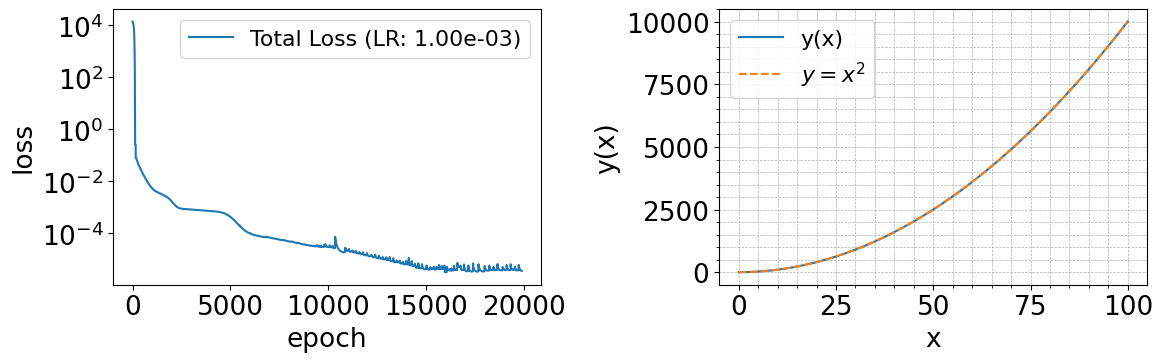

In [11]:
# Assuming some conditions for one type of training
trained_model, training_loss, best_loss = train_model(
    model=ode,
    loss_function=odeloss,
    optimizer=optimizer,
    scheduler=None,
    x=x,
    y_true=y_true,
    x_range=x_range,
    num_epochs=20000, label="x^2",
    x_boundary=x_0, y_boundary=y_0
)

The loss seems to saturate around $10^{-4}$. Looking at the righ-most plot we see that the model approximates very well the desired solution. We can generate a test set and compute the Mean Absolute Percentage Error (MAPE) of the appoximate solution.

In [12]:
x_test = torch.tensor(np.linspace(0, 100, 100, dtype = np.float32)).reshape(100, 1)
y_true = x_test**2 + y_0
x_test = x_test.to(device)


In [13]:
ode.eval()  # Ensure the model is in evaluation mode

with torch.no_grad():
    outputs = ode(x_test, x_0, y_0)  # Assuming ode is your model
    mape = calculate_mape_torch(y_true, outputs.cpu())


print(f"Mean Absolute Percentage Error: {mape:.3f}%")

Mean Absolute Percentage Error: 0.001%


We see that a simple hidden layer with 40 neurons gives a extremely good approximation for the solution when we force the boundary conditions direcly on the network.

## 1.b) Weak-enforcement

We will use the same NN structure, but here we won't force the boudary conditions on the output, but instead we will train the PINN to satisfy the boundary conditions by incorporating this term in the loss.


In [39]:
class ODE(nn.Module):
    def __init__(self, num_hidden_layers, nodes_per_layer, activation_layer):
        super(ODE, self).__init__()

        # Input Layer
        layers = [
              nn.Linear(1, nodes_per_layer),
              activation_layer
          ]

          # Add hidden layers to the list
        for _ in range(num_hidden_layers):
              layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
              layers.append(activation_layer)

          # Output layer
        layers.append(nn.Linear(nodes_per_layer, 1))

        self.net = nn.Sequential(*layers)


        self.init_weights()

    def init_weights(self):
        for layer in self.net.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.1)
                nn.init.constant_(layer.bias, val=0.0)

    def forward(self, x, x_boundary, y_boundary):  # TBD modify function training in order to remove this parameters here
        return self.net(x) 


# Define class to compute the ODE loss.
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode
    
    def ode_loss(self, y, x):

        # Compute the gradients
        dydx = gradients(y, x)  # y'(x)

        #Differential Equation
        diff_eq = (dydx - 2 * x)
        return torch.mean(diff_eq**2)
        
    def ic_loss(self, x_boundary, y_boundary):

        x_boundary = x_boundary * torch.ones(1,1)  # Transforms to a torch tensor.
        x_boundary=x_boundary.to(device)

        y_boundary_pred  = self.ode(x_boundary, 0, 0)  # Approximated boundary condition.
        y_boundary_pred=y_boundary_pred.to(device)

        # Returns the loss associated to the boundary condition.
        return torch.mean((y_boundary_pred - y_boundary)**2)       
   
    def forward(self, x, x_boundary, y_boundary):

        y  = self.ode(x, 0, 0)  # Get the approximate solutions
        
        loss_eq = self.ode_loss(y,x)  # Loss for the equation
        loss_ic = self.ic_loss(x_boundary, y_boundary)  # Loss for the BCs.)

        return loss_eq + loss_ic

In [40]:
ode = ODE(num_hidden_layers = 1, nodes_per_layer = 40,activation_layer = nn.GELU())  # Initializes the NN class.
ode.to(device)
odeloss = ODELoss(ode)  # Intitalizes the loss class.

# Optimizer methods
optimizer = optim.Adam(ode.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/3000))

x = torch.tensor(sorted(np.random.uniform(0, 100, 10000).astype(np.float32))).reshape(10000, 1)
x=x.to(device)
x.requires_grad = True

x_0 = 0 # Location of the boundary condition
y_0 = 5 # Value of the boundary condition

x_range = np.arange(0, 100, 0.1)
y_true = x_range ** 2 + y_0

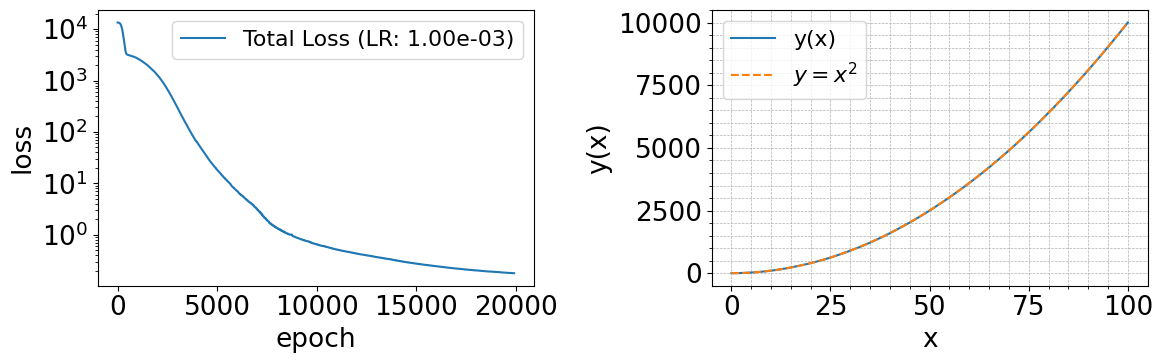

In [41]:
# Assuming some conditions for one type of training
trained_model, training_loss, best_loss = train_model(
    model=ode,
    loss_function=odeloss,
    optimizer=optimizer,
    scheduler=None,
    x=x,
    y_true=y_true,
    x_range=x_range,
    num_epochs=20000, label="x^2",
    x_boundary=x_0, y_boundary=y_0
)

In [42]:
x_test = torch.tensor(np.linspace(0, 100, 100, dtype = np.float32)).reshape(100, 1)
y_true = x_test**2 + y_0
x_test = x_test.to(device)


In [43]:
ode.eval()  # Ensure the model is in evaluation mode

with torch.no_grad():
    outputs = ode(x_test, x_0, y_0)  # Assuming ode is your model
    mape = calculate_mape_torch(y_true, outputs.cpu())


print(f"Mean Absolute Percentage Error: {mape:.3f}%")

Mean Absolute Percentage Error: 0.133%


## Results.

Both method yield extremely good results with such a simple PINN architecture as can be seen by the low error of both methods. However, it is more optimal to force the boundary conditions directly on the network (strong-enforcement).

# Case 2: Second-order ODE:

Let us explore now one step further. We consider here the case of a second order ODE,
$$y''(x) = -y(x),$$
The general solution for this equation is  
$$y(x)=A \sin(x) + B \cos(x),$$
where $A$ and $B$ are free constants that must be determined using boundary conditions.

We will explore both Dirichlet and Neumann boundary conditions.
Let us also restrict this analysis to the case of strong-enforcement.





## Dirichlet Boundary Conditions



Let us impose first the boundary conditions $y(0)=0⇒ B=0$ and $y(\pi/2 )=1⇒ A =1$, yielding
$$y(x) = \sin (x)$$.

We shall see that without more fine-tuning it is difficult to force the periodicity of the function. If the boundary conditions are imposed at $x= \pi/2$ for example, and the training data extends to $x=6\pi$ (see example below), the periodicity the network approximated very well for low $x$ values, but poorly for high $x$ values.

In [49]:
class ODE2(nn.Module):
    def __init__(self):
        super(ODE2, self).__init__()

        # Let's apply a simple ANN with 1 hidden layer. Use GELU activation function
        self.net = nn.Sequential(
            nn.Linear(1, 40), # 1 input -> independent variable x
            nn.GELU(),
            nn.Linear(40, 40),  # hidden layer
            nn.GELU(),
            nn.Linear(40, 1), # 1 outputs -> function y(x)
        )

        # Initialization of weights and bias
        for layer in self.net.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean = 0, std = 0.1)
                nn.init.constant_(layer.bias, val = 0.0) # standard initialization

    def forward(self, x, x_b1, x_b2, y_b1, y_b2):
        # This form enforces that when y_b1 is a solution when x=x_b1 and y_b2
        # is a solution when x = x_b2
        # Care for inputs with x_b1 and x_b2 equal.
        return self.net(x) * (x-x_b1) * (x-x_b2) + y_b1 * (x-x_b2)/(x_b1-x_b2)   + y_b2 * (x-x_b1)/(x_b2-x_b1)

# Define class to compute the ODE loss.
class ODE2Loss(nn.Module):
    def __init__(self, ode2):
        super(ODE2Loss, self).__init__()
        self.ode2 = ode2

    def forward(self, x, x_b1, x_b2, y_b1, y_b2,):

        y  = self.ode2(x, x_b1, x_b2, y_b1, y_b2)  # Get the approximate solutions

        # Compute the gradients
        dydx = gradients(y, x)  # y'(x)
        dy2dx2 = gradients(dydx, x)  # y''(x)

        # Differential Equation Loss:
        # Should be 0 for a solution of the eqs.
        squared_errors = (dy2dx2 + y) ** 2

        eq_loss = torch.mean(squared_errors)

        return eq_loss


In [50]:

ode2 = ODE2()  # Initializes the NN class.
ode2.to(device)

ode2loss = ODE2Loss(ode2)  # Intitalizes the loss class.


optimizer = optim.Adam(ode2.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/5000))

#x = torch.tensor(np.linspace(0, 2*np.pi, 100, dtype = np.float32)).reshape(100, 1)
x = torch.tensor(sorted(np.random.uniform(0, 6*np.pi, 10000).astype(np.float32))).reshape(10000, 1)
x=x.to(device)
x.requires_grad = True

x_1 = 0 # Location of the boundary condition
x_2 = (np.pi)/2  # Location of the boundary condition

y_1 = 0 # Value of the boundary condition
y_2 = 1 # Value of the boundary condition

x_range = np.arange(0, 6*np.pi, 0.1)
y_true = np.sin(x_range)




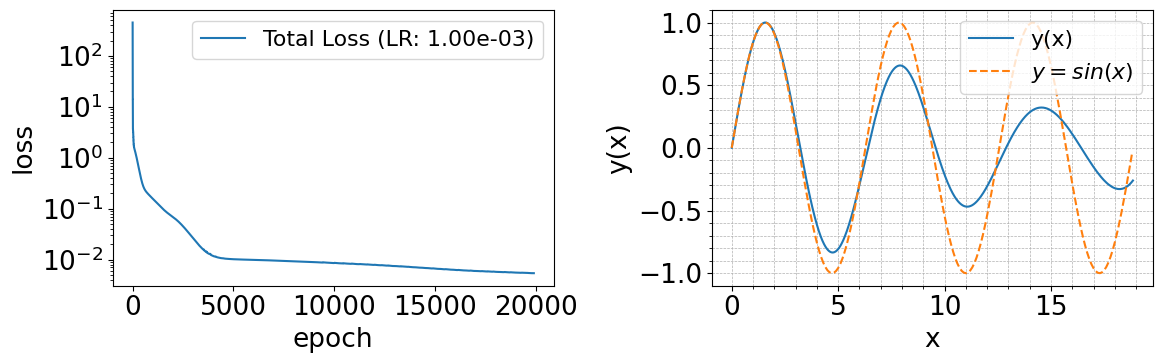

In [53]:
# Assuming some conditions for one type of training
trained_model, training_loss, best_loss = train_model(
    model=ode2,
    loss_function=ode2loss,
    optimizer=optimizer,
    scheduler=None,
    x=x,
    y_true=y_true,
    x_range=x_range,
    num_epochs=20000, label="sin(x)",
    x_b1=x_1, x_b2 = x_2, y_b1=y_1, y_b2=y_2
)

The loss seems to saturate around $10^{-2}$. Looking at the righ-most plot we see that the model fails to approximate the desired solution. Although the loss has not converged completely it is starting to converge. We conclude that our network architecture is not complex enough to catch the properties of the solution.

## Dirichlet Boundary Conditions



Let us see if we can improve the accuracy of the model.
We can implement a few options:
1. We start by simply adding more nodes to the network. This does not seem to work in isolation.
2. We can add more layers to the network. This second point seems to make more difference. Let's see that.


In [34]:
class ODE2(nn.Module):
    def __init__(self, num_hidden_layers, nodes_per_layer, activation_layer):
        super(ODE2, self).__init__()

        # Input Layer
        layers = [
              nn.Linear(1, nodes_per_layer),
              activation_layer
          ]

          # Add hidden layers to the list
        for _ in range(num_hidden_layers):
              layers.append(nn.Linear(nodes_per_layer, nodes_per_layer))
              layers.append(activation_layer)

          # Output layer
        layers.append(nn.Linear(nodes_per_layer, 1))

        self.net = nn.Sequential(*layers)


        self.init_weights()

    def init_weights(self):
        for layer in self.net.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.1)
                nn.init.constant_(layer.bias, val=0.0)

    def forward(self, x, x_b1, x_b2, y_b1, y_b2):
        net_out = self.net(x)
        # Enforcing boundary conditions as before
        return net_out * (x - x_b1) * (x - x_b2) + \
               y_b1 * (x - x_b2) / (x_b1 - x_b2) + \
               y_b2 * (x - x_b1) / (x_b2 - x_b1)

# Define class to compute the ODE loss.
class ODE2Loss(nn.Module):
    def __init__(self, ode2):
        super(ODE2Loss, self).__init__()
        self.ode2 = ode2

    def forward(self, x, x_b1, x_b2, y_b1, y_b2,):

        y  = self.ode2(x, x_b1, x_b2, y_b1, y_b2)  # Get the approximate solutions
        z = torch.log(y)  # In exponential cases.
        
        # Compute the gradients
        dydx = gradients(y, x)  # y'(x)
        dy2dx2 = gradients(dydx, x)  # y''(x)

        # Differential Equation Loss:
        # Should be 0 for a solution of the eqs.
        squared_errors = (dy2dx2 + y) ** 2
       

        eq_loss = torch.mean(squared_errors)

        return eq_loss


In [35]:

ode2 = ODE2(num_hidden_layers = 8, nodes_per_layer = 40,activation_layer = nn.GELU() )  # Initializes the NN class.
ode2.to(device)

ode2loss = ODE2Loss(ode2)  # Intitalizes the loss class.


optimizer = optim.Adam(ode2.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/5000))

#x = torch.tensor(np.linspace(0, 2*np.pi, 100, dtype = np.float32)).reshape(100, 1)
x = torch.tensor(sorted(np.random.uniform(0, 6*np.pi, 10000).astype(np.float32))).reshape(10000, 1)
x=x.to(device)
x.requires_grad = True

x_1 = 0 # Location of the boundary condition
x_2 = (np.pi)/2  # Location of the boundary condition

y_1 = 0 # Value of the boundary condition
y_2 = 1 # Value of the boundary condition

x_range = np.arange(0, 6*np.pi, 0.1)
y_true = np.sin(x_range)




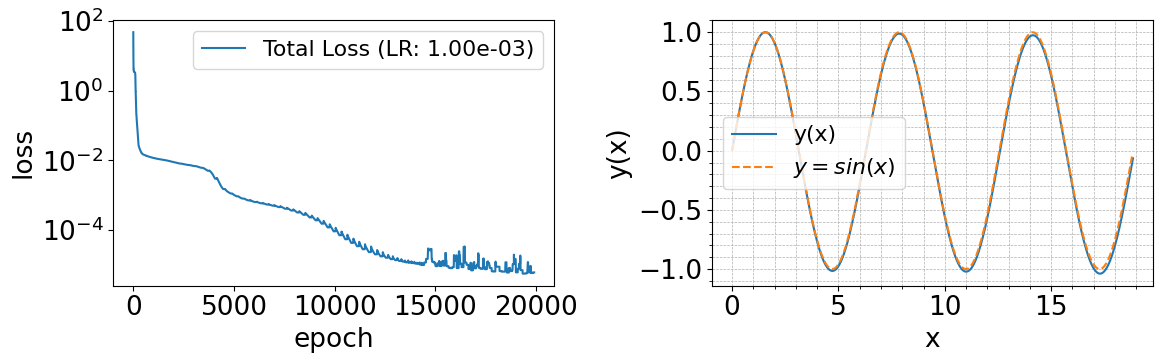

In [36]:
# Assuming some conditions for one type of training
trained_model, training_loss, best_loss = train_model(
    model=ode2,
    loss_function=ode2loss,
    optimizer=optimizer,
    scheduler=None,
    x=x,
    y_true=y_true,
    x_range=x_range,
    num_epochs=20000, label="sin(x)",
    x_b1=x_1, x_b2 = x_2, y_b1=y_1, y_b2=y_2
)

In this model the loss still seems to be decreasing, however looking at the righ plot we see that the solution already has the desired properties. We can generate a test set and compute the Mean Absolute Percentage Error (MAPE) of the approximate solution (see below). As expected, the neural network approximates very well the desired solution as the error is inferior to $1\%$. 

In [39]:
x_test = torch.tensor(sorted(np.random.uniform(0, 6*np.pi, 100).astype(np.float32))).reshape(100, 1)
y_true  = np.sin(x_test)
x_test = x_test.to(device)


In [40]:
ode2.eval()  # Ensure the model is in evaluation mode

with torch.no_grad():
    outputs = ode2(x_test, x_1, x_2, y_1, y_2)  # Assuming ode is your model
    mape = calculate_mape_torch(y_true, outputs.cpu())


print(f"Mean Absolute Percentage Error: {mape:.3f}%")

Mean Absolute Percentage Error: 0.272%


Is this a architecture good for other second-order ODES? Let's check it.

In [42]:
# Loss function considering a differential equation for an exponential function.
class ODE2Loss(nn.Module):
    def __init__(self, ode2):
        super(ODE2Loss, self).__init__()
        self.ode2 = ode2

    def forward(self, x, x_b1, x_b2, y_b1, y_b2,):

        y  = self.ode2(x, x_b1, x_b2, y_b1, y_b2)  # Get the approximate solutions

        # Compute the gradients
        dydx = gradients(y, x)  # y'(x)
        dy2dx2 = gradients(dydx, x)  # y''(x)

        # Differential Equation Loss:
        # Should be 0 for a solution of the eqs.
        squared_errors = (dy2dx2 - 6 * x) ** 2

        eq_loss = torch.mean(squared_errors)

        return eq_loss

In [48]:

ode2loss = ODE2Loss(ode2)  # Intitalizes the loss class.

# Generate some colocation points in the domain. Following the original paper 10000 seems to be good for PDES.
x = torch.tensor(sorted(np.random.uniform(0, 8, 10000).astype(np.float32))).reshape(10000, 1)
x=x.to(device)
x.requires_grad = True

x_1 = 0 # Location of the boundary condition
x_2 = 2  # Location of the boundary condition

y_1 = 1 # Value of the boundary condition
y_2 = 9 # Value of the boundary condition

x_range = np.arange(0, 8, 0.01)
y_true = (x_range) ** 3 +1




KeyboardInterrupt: 

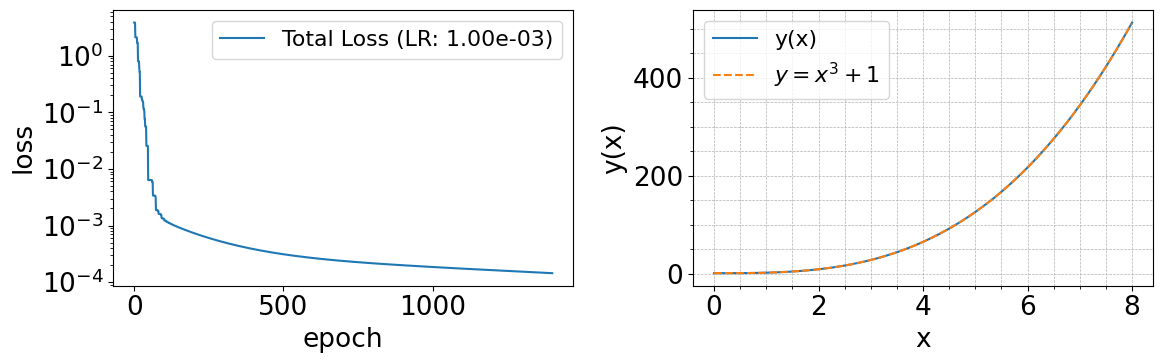

In [49]:
# Assuming some conditions for one type of training
trained_model, training_loss, best_loss = train_model(
    model=ode2,
    loss_function=ode2loss,
    optimizer=optimizer,
    scheduler=None,
    x=x,
    y_true=y_true,
    x_range=x_range,
    num_epochs=20000, label="x^3 +1",
    x_b1=x_1, x_b2 = x_2, y_b1=y_1, y_b2=y_2
)

In [ ]:
x_test = torch.tensor(sorted(np.random.uniform(0, 6*np.pi, 100).astype(np.float32))).reshape(100, 1)
y_true  = np.exp(x_test)
x_test = x_test.to(device)

In [ ]:
ode2.eval()  # Ensure the model is in evaluation mode

with torch.no_grad():
    outputs = ode2(x_test, x_1, x_2, y_1, y_2)  # Assuming ode is your model
    mape = calculate_mape_torch(y_true, outputs.cpu())


print(f"Mean Absolute Percentage Error: {mape:.3f}%")

## Neumann Boundary conditions

Above we saw the modifications that we needed to implement in the PINN architecture for a second order ODE, in order to obtain good results. 

# Case 2: System of Coupled ODEs

Here we solve the system of ODEs for the sine and cosine functions.

$$s'(x) = c(x),$$
$$c'(x) = -s(x),$$

As expected the solutions are of the form $c(x)=A\cos(x + \psi)$ and $s(x)=A\sin(x + \psi)$.

Let us set the initial conditions as in order to fix the phase and amplitude.

$$s(0) = 0, \;c(0) = 1.$$
<br>


In [ ]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        # Let's apply a simple ANN with 1 hidden layer. Use GELU activation function
        self.net = nn.Sequential(
            nn.Linear(1, 40), # 1 input -> independent variable x
            nn.GELU(),
            nn.Linear(40, 40),  # hidden layer
            nn.GELU(),
            nn.Linear(40, 2), # 2 outputs -> function c(x) and s(x)
        )

        # Initialization of weights and bias
        for layer in self.net.modules():
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean = 0, std = 0.1)
                nn.init.constant_(layer.bias, val = 0.0) # standard initialization

    def forward(self, x):
        return self.net(x)

# Define class to compute the ODE loss.
class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode

    def forward(self, x):

        f  = self.ode(x)  # Get the approximate solutions

        # Get the approximate solutions for c(x) and s(x)
        c, s = map(lambda i:  f[:,[i]], range(2))

        # Compute the gradients
        dcdx = gradients(c, x)  # c'(x)
        dsdx = gradients(s, x)  # s'(x)

        # Differential Equation Loss:
        # Should be 0 for a solution of the eqs.
        eq_loss = torch.mean((dcdx + s)**2 + (dsdx - c)**2)

        # Initial Condition Loss:
        # We impose the boundary conditions on the equations.
        zero_vals = self.ode(torch.zeros(1,1))
        ic_loss = (zero_vals[0,0] - 1)**2 + zero_vals[0,1]**2

        return eq_loss, ic_loss


In [ ]:
ode = ODE()  # Initializes the NN class.
odeloss = ODELoss(ode)  # Intitalizes the loss class.


optimizer = optim.Adam(ode.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/2000))

x = torch.tensor(np.linspace(0, 2 * np.pi, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

x_range = np.arange(0, 2*np.pi, 0.1)
c_true = np.cos(x_range)
s_true = np.sin(x_range)




################## Training and Plotting ##################

# Array for saving the loss values
loss_hist = []  # Total loss
ic_loss_hist = []  # Boundary condition loss
eq_loss_hist = []  # ODE loss

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(3000):
    try:
        optimizer.zero_grad()

        eq_loss, ic_loss = odeloss(x)
        loss = eq_loss + ic_loss
        loss.backward()
        optimizer.step()

        #scheduler.step()
        loss_hist.append(loss.item())
        ic_loss_hist.append(ic_loss.item())
        eq_loss_hist.append(eq_loss.item())

        if epoch % 100 == 0:

            # Visualization for the Loss
            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            ax1.plot(ic_loss_hist)
            ax1.plot(eq_loss_hist)
            ax1.legend(["total loss","IC loss", "EQ Loss"], fontsize='small')

            # Visualization for the solutions
            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('(c, s)')
            ax2.plot(x.cpu().detach().numpy(), ode(x)[:, 0].cpu().detach().numpy())
            ax2.plot(x.cpu().detach().numpy(), ode(x)[:, 1].cpu().detach().numpy())
            ax2.plot(x_range, c_true, color='#1f77b4', linestyle = '--') #Plot for the exact solution of cosine
            ax2.plot(x_range, s_true, color = '#ff7f0e', linestyle = '--') #Plot for the exact solution of sine

            ax2.legend(["c(x)","s(x)", "cos(x)", "sin(x)"], fontsize='small')
            plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

            plt.minorticks_on()


            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()

    except KeyboardInterrupt:
        break


As expected the output of the neural network for $c(x)$ and $s(x)$ represent the cosine and the sine.

 The loss function decreases and is low, validating also the method. Just by looking at the plot on the right one can see that the solutions of the PINN (solid lines) approximate very well the exact solutions (dashed lines).

 Let us now repeat the exercise but impose the boundary conditions using strong-enforcement. (TBD)


# Simple Eigenvalue Problem: Vibrating String

Let us consider the case of a oscillating string. The equation that governs waves on strings is given by (we set $c=1$ for simplicity):

$$-\frac{\partial^2 \Psi(t,x)}{\partial t^2} +\frac{\partial^2 \Psi(t,x)}{\partial x^2}=0 $$.

Instead of solving the full partial differential equation (PDE), it is often useful to look at the frequency-domain by taking the fourier decomposition of the function.

$$ $$

By doing this transformation our single PDE reduces to a system of infinite (but separable) ordinary differential equations (ODEs).

$$\psi''(x) + \lambda^2 \psi(x) = 0$$

One option is to provide a value of $\lambda$ and solve the equation. Another option is to impose boundary conditions and reduce this equation to an eigenvalue problem.


Here we want to apply NNs to solve the eigenvalue problem


$$\psi''(x) + \lambda^2 \psi(x) = 0, \quad {\rm with} \quad \psi(0) = \psi(1) = 0.$$

Let us start by checking what we expect the solution to be:
<br>

In [ ]:
psi = sp.Function('psi')
x = sp.symbols('x')
lam = sp.symbols('lam')

In [ ]:
diff_eq1 = sp.Eq(psi(x).diff(x).diff(x) , - lam ** 2 * psi(x))

solution = sp.dsolve(diff_eq1, psi(x))
print(solution)



In [ ]:
C1, C2 = sp.symbols('C1 C2')
general_solution = solution.rhs  # Get the right-hand side of the solution


In [ ]:
# Apply the first boundary condition f(0) = 0
bc1 = general_solution.subs(x, 0).subs(psi(0), 0)
solutions = sp.solve((bc1), (C2), dict=True)
print(solutions)
replaced_solution = general_solution.subs(C2,-C1) #This is the solution with the boundary condition at x=0 satisfied
print(replaced_solution)


We can easily see the expression at x=1:

In [ ]:
replaced_solution.subs(x,1)

It is easy to see that this boundary condition is only satisfied when

$$\lambda = n \times \pi, $$
and $n$ is an integer number.

Our neural network should find sinusoidal solutions with this eigenvalue.

In [ ]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        self.lam = nn.Parameter(torch.tensor(7., requires_grad=True))  # Adjusted for the first overtone

        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.GELU(),
            nn.Linear(40, 40),
            nn.GELU(),
            nn.Linear(40, 1),
        ) # 1 hidden layer is enough

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.3)
                nn.init.constant_(m.bias, val = 0)

    def forward(self, x):
        return self.net(x) * x * (1 - x) #This is another way to force the boundary conditions
def node_penalty(f, expected_sign_changes=1):

    # Calculate the sign of f at each point
    sign_f = torch.sign(f)

    # Calculate the difference in sign between consecutive elements
    # A non-zero difference indicates a sign change
    product_consecutive = f[1:] * f[:-1] #If the product of two consecutive numbers is negative, it means that the sign changed. (if the function is oscillating around 0)

    sign_changes =  (product_consecutive < 0).float()



    # Count the number of sign changes (non-zero entries imply a sign change)
    num_sign_changes = torch.sum(sign_changes).float()

    # Calculate the penalty as the squared difference between the observed and expected sign changes
    penalty = (((num_sign_changes - expected_sign_changes) ** 2))/(expected_sign_changes + num_sign_changes+0.001) ** 2

    return penalty, num_sign_changes

def amplitude_regularization(f, target_amplitude):
    # Calculate the deviation of f's peak (or average) amplitude from the target
    amplitude_deviation = torch.abs(torch.max(torch.abs(f)) - target_amplitude)
    return amplitude_deviation**2

class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode

    def forward(self, x):
        f  = self.ode(x)
        d2f = gradients(f, x, 2)
        base_loss = torch.mean((d2f + f*self.ode.lam**2)**2)
        #regularization = torch.mean(torch.abs(f) - 1)**2
        regularization = torch.tensor(0)
        # Node penalty encouraging the presence of a node (zero crossing)
        node_penalty_term , num_sign_changes_term = node_penalty(f)
        amplitude_loss = amplitude_regularization(f,1)
        loss = base_loss + 1*regularization  +  node_penalty_term + amplitude_loss
      #  loss = torch.mean((d2f + f*self.ode.lam**2)**2+ (torch.mean(f) )**2)

        return loss, node_penalty_term, num_sign_changes_term, regularization

In [ ]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []
regularization_loss_hist = [] #For checking the contribution of the regularization loss.
node_loss_hist = [] # For checking the contribution of the node loss.

optimizer = optim.Adam(ode.parameters(), lr=5e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.01)**(1/2000))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

x = torch.tensor(np.linspace(0, 1, 500, dtype = np.float32)).reshape(500, 1)
x.requires_grad = True

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6));
font = {'size'   : 19}
plt.rc('font', **font)
x_vals = np.linspace(0, 1, 100)
c_vals = -0.02*np.sin(2* np.pi * x_vals)
for epoch in range(3001):
    try:
        optimizer.zero_grad()

        loss, node_penalty_term, num_sign_changes_term, regularization_term = odeloss(x)
        loss.backward()
        optimizer.step()

        scheduler.step()
        loss_hist.append(loss.item())
        regularization_loss_hist.append(regularization_term.item())
        node_loss_hist.append(node_penalty_term.item())

        if epoch % 100 == 0:
            #print(f"Epoch {epoch}, Node Penalty Term: {node_penalty_term.item()}, Sign changes: {num_sign_changes_term.item()}")
            plt.suptitle(f'$\lambda/\pi = {ode.lam.item() / np.pi}$')

            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            ax1.plot(regularization_loss_hist)
            ax1.plot(node_loss_hist)

            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.plot(x.cpu().detach().numpy(), ode(x).cpu().detach().numpy())
            ax2.plot(x_vals, c_vals, color='#1f77b4', linestyle = '--') #Plot for the exact solution of cosine

            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()

    except KeyboardInterrupt:
        break


Finding the fundamental mode is easy.
However the network is having trouble finding higher overtones.